In [1]:
import sys
sys.path.append("../../code")

In [2]:
import gen

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel,outchannel,kernel_size=3,padding=1,stride=stride,bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.right = nn.Sequential()
        
        if(inchannel != outchannel):
            self.right = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=3, padding=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel),
            )

    def forward(self, x):
        out = self.left(x)
        out += self.right(x)
        out =F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=1)
        self.conv2 = nn.Conv2d(128,128,3,stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=1)
        self.conv3 = nn.Conv2d(256, 256, 3, stride=2)
        #self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=1)
        self.conv4 = nn.Conv2d(256,256,6)
        self.fc = nn.Linear(256, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        layer = []
        for i in range(num_blocks):
            layer.append(block(self.inchannel,channels,stride))
            self.inchannel = channels
        #
        return nn.Sequential(*layer)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.conv2(out)
        out = self.layer3(out)
        out = self.conv3(out)
        #out = self.layer4(out)
        out = self.conv4(out)
        #out = F.avg_pool2d(out,4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def ResNet18():
    return ResNet(ResidualBlock)


In [5]:
train_model = ResNet18()

In [6]:
#adv_train(data_set, adv_sample_path, sample_num, sample_shape, train_model, model_lossfun, model_optimizer, config, METHOD_dataset_NET_TNET)
data_set = 'mnist'
adv_sample_path = '../sample/FGSM_mnist_ResNet18/train'
sample_num = 60000
sample_shape = [1,28,28]
model_lossfun = nn.MSELoss()
model_optimizer = optim.SGD(train_model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
config = 'FGSM_mnist_ResNet18_ResNet18.json'
METHOD_dataset_NET_TNET = 'FGSM_mnist_ResNet18_ResNet18'

In [7]:
gen.adv_train(
    data_set, 
    adv_sample_path, 
    sample_num, 
    sample_shape, 
    train_model, 
    model_lossfun, 
    model_optimizer, 
    config, 
    METHOD_dataset_NET_TNET)

epoch:0/100
loss:0.11521361,cost:148.9253s
epoch:1/100
loss:0.05236487,cost:151.6028s
epoch:2/100
loss:0.04169222,cost:152.6506s
epoch:3/100
loss:0.03623442,cost:153.8233s
epoch:4/100
loss:0.03270666,cost:154.0971s
epoch:5/100
loss:0.03014812,cost:153.7338s
epoch:6/100
loss:0.02816257,cost:154.1898s
epoch:7/100
loss:0.02656217,cost:153.1381s
epoch:8/100
loss:0.02523675,cost:151.1624s
epoch:9/100
loss:0.02410923,cost:150.8343s
epoch:10/100
loss:0.02313090,cost:150.7666s
epoch:11/100
loss:0.02227034,cost:150.5544s
epoch:12/100
loss:0.02150652,cost:150.5702s
epoch:13/100
loss:0.02082031,cost:150.5150s
epoch:14/100
loss:0.02019834,cost:150.6340s
epoch:15/100
loss:0.01963117,cost:150.6200s
epoch:16/100
loss:0.01911240,cost:150.5038s
epoch:17/100
loss:0.01863193,cost:150.5930s
epoch:18/100
loss:0.01818600,cost:150.5935s
epoch:19/100
loss:0.01777058,cost:150.6371s
epoch:20/100
loss:0.01738101,cost:150.4607s
epoch:21/100
loss:0.01701524,cost:150.4350s
epoch:22/100
loss:0.01667161,cost:150.7325

In [7]:
import val

In [8]:
adv_model = torch.load('../model/adv_train/FGSM_mnist_ResNet18_ResNet18/model.pkl')

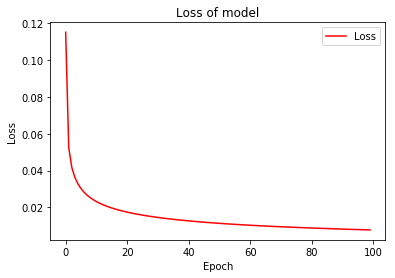

In [9]:
# make_loss_curve(loss_file, file_type)
val.make_loss_curve(
    loss_file = '../model/adv_train/FGSM_mnist_ResNet18_ResNet18/loss.txt',
    file_type = 'adv_train')

In [10]:
import tst

In [11]:
tst.accuracy_test(
    model = adv_model, 
    data_set = 'mnist'
    )

accuracy:99.360000%


## FGSM

In [12]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/FGSM_mnist_FNN/test',
    sample_num = 10000,
    sample_shape = [1,28,28]
)

fooling_rate:0.840000%


In [13]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/FGSM_mnist_LeNet/test',
    sample_num = 10000,
    sample_shape = [1,28,28]
)

fooling_rate:1.150000%


In [14]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/FGSM_mnist_ResNet18/test',
    sample_num = 10000,
    sample_shape = [1,28,28]
)

fooling_rate:0.540000%


## JSMA

In [15]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/JSMA_mnist_FNN/test',
    sample_num = 10000,
    sample_shape = [1,28,28]
)

fooling_rate:10.550000%


In [16]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/JSMA_mnist_LeNet/test',
    sample_num = 10000,
    sample_shape = [1,28,28]
)

fooling_rate:8.990000%


In [17]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/JSMA_mnist_ResNet18/test',
    sample_num = 10000,
    sample_shape = [1,28,28]
)

fooling_rate:3.220000%


## DEEPFOOL

In [18]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/DEEPFOOL_mnist_FNN/test',
    sample_num = 10000,
    sample_shape = [1,28,28]
)

fooling_rate:20.690000%


In [19]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/DEEPFOOL_mnist_LeNet/test',
    sample_num = 10000,
    sample_shape = [1,28,28]
)

fooling_rate:11.350000%


In [20]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/DEEPFOOL_mnist_ResNet18/test',
    sample_num = 10000,
    sample_shape = [1,28,28]
)

fooling_rate:0.700000%


## PGD

In [21]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/PGD_mnist_FNN/test',
    sample_num = 10000,
    sample_shape = [1,28,28]
)

fooling_rate:2.000000%


In [22]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/PGD_mnist_LeNet/test',
    sample_num = 10000,
    sample_shape = [1,28,28]
)

fooling_rate:2.940000%


In [23]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/PGD_mnist_ResNet18/test',
    sample_num = 10000,
    sample_shape = [1,28,28]
)

fooling_rate:0.840000%


## THREAT

In [24]:
# robustness_test(model, adv_sample_path, sample_num, sample_shape):
tst.robustness_test(
    model = adv_model,
    adv_sample_path = '../sample/THREAT_mnist/test',
    sample_num = 10000,
    sample_shape = [1,28,28]
)

fooling_rate:37.300000%
